## This notebook shows how to use `grizli` to

model contamination + continuum + emission for G102/G141 observations of a single object in the CLEAR GS1 field. The final products are 1D and 2D spectra and line maps.

These series of notebooks draw heavily from Gabe Brammer's existing `grizli` notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with examples specific for the CLEAR survey.

In [1]:
%matplotlib inline
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import drizzlepac
import grizli
import glob
from grizli import utils
import importlib
from grizli.prep import process_direct_grism_visit
from hsaquery import query, overlaps
from grizli.pipeline import auto_script
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import os
from grizli.pipeline import photoz
from astropy.table import Table
import eazy
from IPython.display import Image


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


### The results of this notebook are available for download on the team archive (Prep_premade_GS1.tar.gz):

https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/





### ***The following paths need to be changed for your filesystem.*** [HOME_PATH] is where the raw data, reduced data, and `grizli` outputs will be stored. [PATH_TO_CATS] is where the catalogs are stored and must include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
        
the [PATH_TO_CATS] files are available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/

In [2]:
field           = 'GS1'
ref_filter      = 'F105W'
HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_SCRIPTS = '/Users/rsimons/Desktop/git/clear_local/example_notebooks'
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'
PATH_TO_RAW     = glob.glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob.glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500 # really only necessary for GDN
            self.radec_catalog = PATH_TO_CATS + '/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')



'\ndef readEazyBinary(MAIN_OUTPUT_FILE=\'photz\', OUTPUT_DIRECTORY=\'./OUTPUT\', CACHE_FILE=\'Same\'):\n\n    """\n    Author: Gabe Brammer\n    This function has been clipped from eazyPy.py in the threedhst git respository\n    https://github.com/gbrammer/threedhst/tree/master/threedhst\n\n    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE=\'photz\',                                                 OUTPUT_DIRECTORY=\'./OUTPUT\',                                                 CACHE_FILE = \'Same\')\n\n    Read Eazy BINARY_OUTPUTS files into structure data.\n    \n    If the BINARY_OUTPUTS files are not in \'./OUTPUT\', provide either a relative or absolute path\n    in the OUTPUT_DIRECTORY keyword.\n    \n    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+\'.tempfilt\'.\n    Specify the full filename if otherwise. \n    """\n    \n    #root=\'COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU\'\n    \n    root = OUTPUT_DIRECTORY+\'/\'+MAIN_OUTPUT_FILE\n    \n    ##

In [3]:
os.chdir(PATH_TO_PREP)
files = glob.glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [4]:
product_names = np.array([visit['product'] for visit in visits])
filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])


In [5]:
all_grism_files = []
all_direct_files = []

ref_filter_1 = 'F105W' 
ref_filter_2 = 'F140W'

ref_grism_1 = 'G102'
ref_grism_2 = 'G141'

for v, visit in enumerate(visits):
    product = product_names[v]
    basename = basenames[v]
    filt1 = filter_names[v]
    if (ref_filter_1.lower() in filt1) or (ref_filter_2.lower() in filt1):
        all_direct_files.extend(visit['files'])
        grism_index_1 = np.where((basenames == basename) & (filter_names == ref_grism_1.lower()))[0]
        grism_index_2 = np.where((basenames == basename) & (filter_names == ref_grism_2.lower()))[0]
        if len(grism_index_1) > 0:
            all_grism_files.extend(visits[grism_index_1[0]]['files'])
        if len(grism_index_2) > 0:
            all_grism_files.extend(visits[grism_index_2[0]]['files'])
        
print ('Number of direct files:', len(all_direct_files))
print ('Number of grism files:', len(all_grism_files))


Number of direct files: 16
Number of grism files: 28


<h1><center>Contamination models</center></h1>

The contamination models have been pre-made and can be downloaded from (Prep_premade_GS1.tar.gz):

https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/

untar the file

    tar -xzvf Prep_premade_GS1.tar.gz
    
and move the *GrismFLT.pkl and *GrismFLT.fits files to your working PREP/ directory.


In [6]:
p = Pointing(field = field, ref_filter = ref_filter_1)
print('Initializing (or loading pre-existing) contamination models...')

grp = GroupFLT(grism_files=all_grism_files, 
               direct_files=[], 
               ref_file = p.ref_image,
               seg_file = p.seg_map,
               catalog  = p.catalog,
               pad=p.pad,
               cpu_count=8)

Initializing (or loading pre-existing) contamination models...
Load ibhj01iqq.01.GrismFLT.fits!
Load ibhj01ixq.01.GrismFLT.fits!
Load ibhj01j4q.01.GrismFLT.fits!
Load ibhj01jbq.01.GrismFLT.fits!
Load icxt09f0q.01.GrismFLT.fits!
Load icxt09f2q.01.GrismFLT.fits!
Load icxt09f5q.01.GrismFLT.fits!
Load icxt09f7q.01.GrismFLT.fits!
Load icxt10dbq.01.GrismFLT.fits!
Load icxt10deq.01.GrismFLT.fits!
Load icxt10diq.01.GrismFLT.fits!
Load icxt10dkq.01.GrismFLT.fits!
Load icxt07dxq.01.GrismFLT.fits!
Load icxt07dzq.01.GrismFLT.fits!
Load icxt07e2q.01.GrismFLT.fits!
Load icxt07e4q.01.GrismFLT.fits!
Load icxt08e7q.01.GrismFLT.fits!
Load icxt08e9q.01.GrismFLT.fits!
Load icxt08ecq.01.GrismFLT.fits!
Load icxt08eeq.01.GrismFLT.fits!
Load icxt11qiq.01.GrismFLT.fits!
Load icxt11qkq.01.GrismFLT.fits!
Load icxt11qnq.01.GrismFLT.fits!
Load icxt11qpq.01.GrismFLT.fits!
Load icxt12qvq.01.GrismFLT.fits!
Load icxt12qxq.01.GrismFLT.fits!
Load icxt12r0q.01.GrismFLT.fits!
Load icxt12r2q.01.GrismFLT.fits!
Files loaded 

### Creating new contamination models

In [7]:
compute_models = False
if compute_models:
    print('Computing first-pass contamination models...')
    grp.compute_full_model(mag_limit = 25)

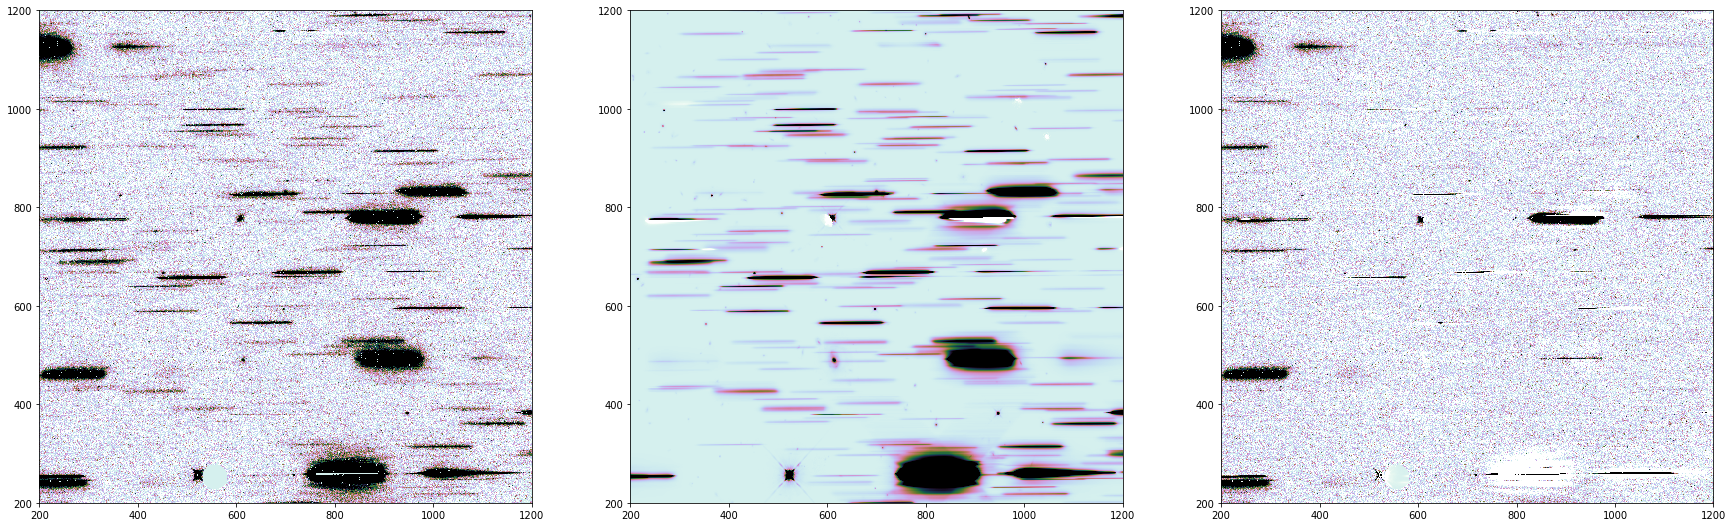

In [8]:
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    



In [9]:
if compute_models:
    print('Re-computing continuum models, but with higher-order polynomials..')
    grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

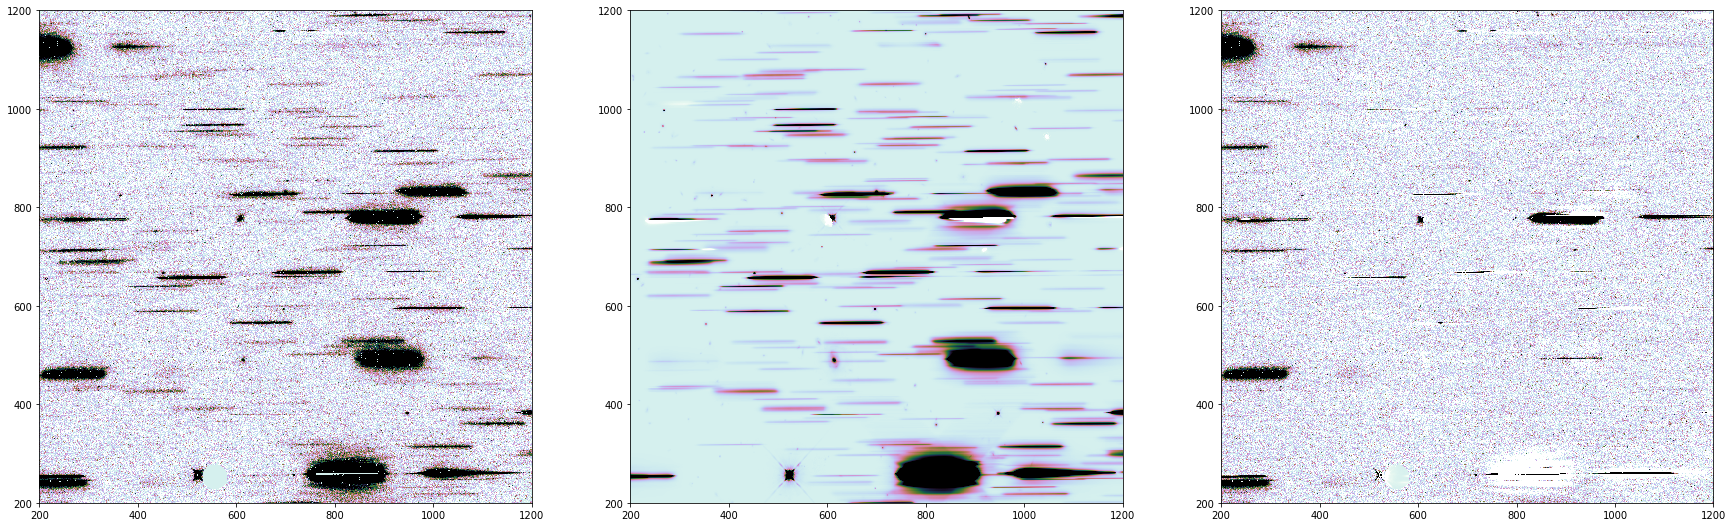

In [10]:
fig.clf()
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    
    

In [11]:
if compute_models:
    print('Saving contamination models')
    grp.save_full_data()


In [12]:
eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', 
                         path_is_env=False)
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Load individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=p.translate_file, 
                        zeropoint_file=None, params=p.params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez, grizli_templates=templ0, zgrid=ez.zgrid)




/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/

<h1><center>Fitting a single object, ID = 43404 </center></h1>

### Retrieve and write-out the 2D spectrum of a single object. These cutouts are referred to as "beams".

In [13]:
id_fit = 43403
beams = grp.get_beams(id_fit, size=80)
print("beams: ", beams)
mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
mb.write_master_fits()



beams:  [<grizli.model.BeamCutout object at 0x1c94b771d0>, <grizli.model.BeamCutout object at 0x1c94b77710>, <grizli.model.BeamCutout object at 0x1ca451dc18>, <grizli.model.BeamCutout object at 0x1c848c7cc0>, <grizli.model.BeamCutout object at 0x1cbcb4ab70>, <grizli.model.BeamCutout object at 0x1cbcb74f98>, <grizli.model.BeamCutout object at 0x1cc6f6cf98>, <grizli.model.BeamCutout object at 0x1cc6f8fd30>, <grizli.model.BeamCutout object at 0x1cc8454c18>, <grizli.model.BeamCutout object at 0x1cc8b4ffd0>, <grizli.model.BeamCutout object at 0x1cc8b75f98>, <grizli.model.BeamCutout object at 0x1cc8f0ae48>, <grizli.model.BeamCutout object at 0x1cc9605c88>, <grizli.model.BeamCutout object at 0x1cc9629f98>, <grizli.model.BeamCutout object at 0x1ccae1af98>, <grizli.model.BeamCutout object at 0x1ccae3dd30>, <grizli.model.BeamCutout object at 0x1ccb1d0c18>, <grizli.model.BeamCutout object at 0x1ccb8cefd0>, <grizli.model.BeamCutout object at 0x1ccb8f2f98>, <grizli.model.BeamCutout object at 0x1ccb

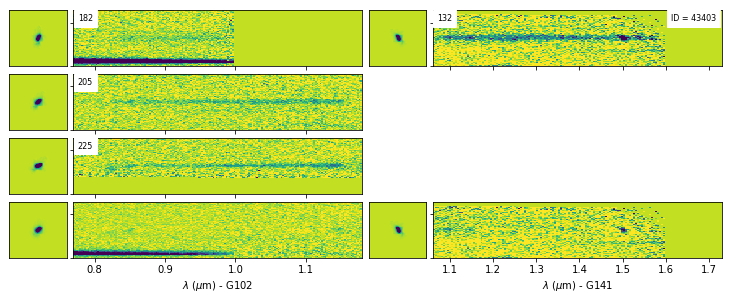

In [14]:
# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(
    wave=wave, 
    order=7,
    line=False)

pfit = mb.template_at_z(
    z=0, 
    templates=poly_templates, 
    fit_background=True, 
    fitter='lstsq', 
    fwhm=1400, 
    get_uncertainties=2)


hdu, fig = mb.drizzle_grisms_and_PAs(
    size=32, 
    fcontam=0.2, 
    flambda=False, 
    scale=1, 
    pixfrac=0.5, 
    kernel='point', 
    make_figure=True, 
    usewcs=False, 
    zfit=pfit,
    diff=True)
# Save drizzled ("stacked") 2D trace as PNG and FITS
fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)


1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_43403.stack.fits
  G102 G141
User templates! N=16 

  0.0000    7747.0 (0.0000) 1/377
  0.0040    7746.6 (0.0040) 2/377
  0.0080    7747.1 (0.0040) 3/377
  0.0121    3367.6 (0.0121) 4/377
  0.0161    3367.9 (0.0121) 5/377
  0.0202    3368.

  0.9818    3331.3 (0.1008) 172/377
  0.9897    3324.1 (0.1008) 173/377
  0.9977    3318.4 (0.1008) 174/377
  1.0057    3315.6 (0.1008) 175/377
  1.0138    3311.6 (1.0138) 176/377
  1.0218    3310.6 (1.0218) 177/377
  1.0299    3307.4 (1.0299) 178/377
  1.0381    3299.1 (1.0381) 179/377
  1.0462    3292.4 (1.0462) 180/377
  1.0544    3291.5 (1.0544) 181/377
  1.0627    3290.4 (1.0627) 182/377
  1.0709    3282.6 (1.0709) 183/377
  1.0792    3273.4 (1.0792) 184/377
  1.0876    3260.8 (1.0876) 185/377
  1.0959    3253.2 (1.0959) 186/377
  1.1043    3251.1 (1.1043) 187/377
  1.1128    3246.5 (1.1128) 188/377
  1.1212    3240.9 (1.1212) 189/377
  1.1297    3239.0 (1.1297) 190/377
  1.1383    3241.6 (1.1297) 191/377
  1.1468    3244.7 (1.1297) 192/377
  1.1555    3239.4 (1.1297) 193/377
  1.1641    3236.3 (1.1641) 194/377
  1.1728    3236.2 (1.1728) 195/377
  1.1815    3235.5 (1.1815) 196/377
  1.1902    3232.4 (1.1902) 197/377
  1.1990    3226.8 (1.1990) 198/377
  1.2078    3216.4 (1.2078) 

  3.2207    4159.5 (1.2796) 361/377
  3.2376    4176.6 (1.2796) 362/377
  3.2546    4190.6 (1.2796) 363/377
  3.2716    4184.3 (1.2796) 364/377
  3.2888    4165.7 (1.2796) 365/377
  3.3060    4166.5 (1.2796) 366/377
  3.3232    4190.6 (1.2796) 367/377
  3.3405    4218.5 (1.2796) 368/377
  3.3579    4242.6 (1.2796) 369/377
  3.3754    4261.8 (1.2796) 370/377
  3.3929    4278.0 (1.2796) 371/377
  3.4106    4292.2 (1.2796) 372/377
  3.4282    4384.9 (1.2796) 373/377
  3.4460    4400.9 (1.2796) 374/377
  3.4638    4417.5 (1.2796) 375/377
  3.4817    4434.5 (1.2796) 376/377
  3.4997    4454.6 (1.2796) 377/377
First iteration: z_best=1.2796

- 1.2758    2864.3 (1.2758) 1/33
- 1.2763    2849.8 (1.2763) 2/33
- 1.2768    2835.3 (1.2768) 3/33
- 1.2773    2821.2 (1.2773) 4/33
- 1.2778    2807.5 (1.2778) 5/33
- 1.2783    2794.4 (1.2783) 6/33
- 1.2788    2781.9 (1.2788) 7/33
- 1.2793    2770.3 (1.2793) 8/33
- 1.2798    2759.5 (1.2798) 9/33
- 1.2803    2749.7 (1.2803) 10/33
- 1.2808    2741.0 (1.280

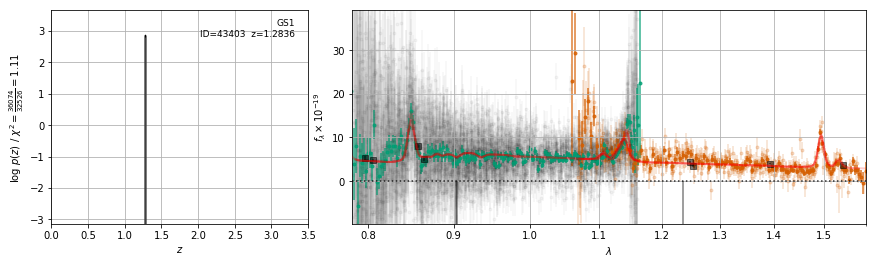

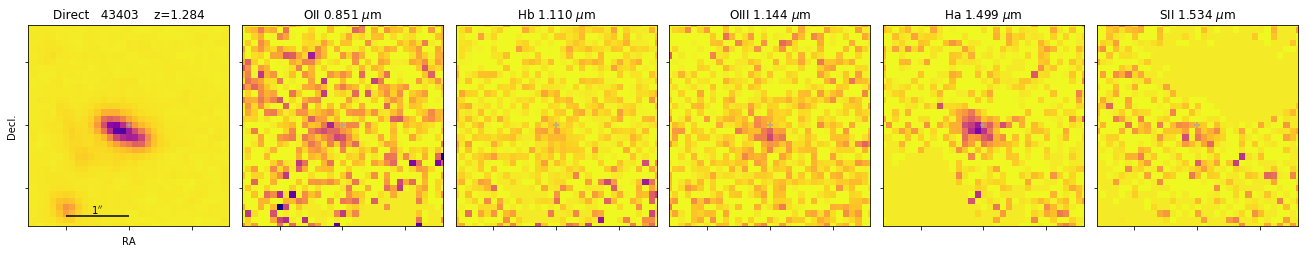

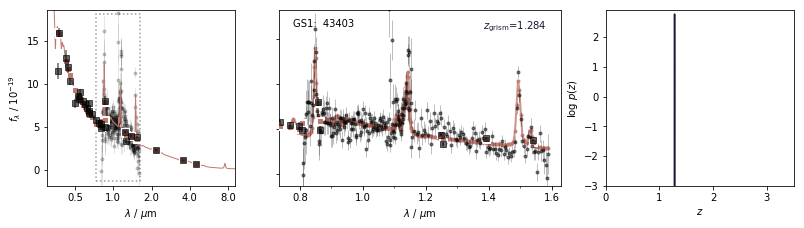

In [15]:
tab = utils.GTable()
tab['ra'] = [mb.ra]
tab['dec'] = [mb.dec]
tab['id'] = id_fit
phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
out = grizli.fitting.run_all(
    id_fit, 
    t0=templ0, 
    t1=templ1, 
    fwhm=1200, 
    zr=[0.0, 3.5], 
    dz=[0.004, 0.0005], 
    fitter='nnls',
    group_name=field,
    fit_stacks=True, 
    prior=None, 
    fcontam=0.,
    pline=pline, 
    mask_sn_limit=7, 
    fit_only_beams=False,
    fit_beams=True, 
    root=field,
    fit_trace_shift=False, 
    phot=phot, 
    verbose=True, 
    scale_photometry= 0, 
    show_beams=True)

In [16]:
mb, st, fit, tfit, line_hdu = out
fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

fit_hdu.info()
# same as the fit table above, redshift fit to the stacked spectra
fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

templ = Table(fit_hdu['TEMPL'].data)
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

# Helper script for plotting them, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
plt.close('all')

Filename: GS1_43403.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  ZFIT_STACK    1 BinTableHDU    238   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8391R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        SII ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   SII ImageHDU        24   (80, 80)   float32   
  9  CONTAM      SII ImageHDU        24   (80, 80)   float32   
 10  LINEWHT     SII ImageHDU        24   (80, 80)   float32   
 11  LINE        Ha  ImageHDU        24   (80, 80)   float32   
 12  CONTINUUM   Ha  ImageHDU        24   (80, 80)   float32   
 13  CONTAM      Ha  ImageHDU        24   (80, 80) 

<h1><center>Grizli products</center></h1>

### Stack of Grism orients

left columns:  G102

right columns: G141

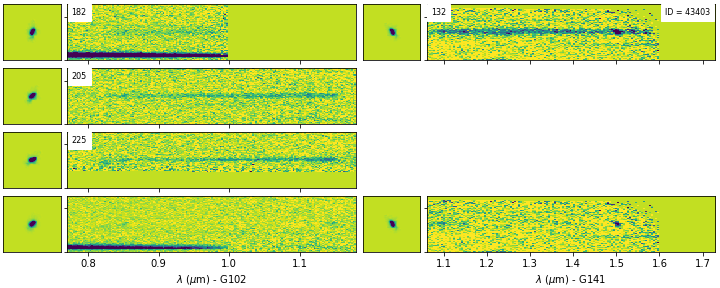

In [17]:
Image(filename = PATH_TO_PREP + '/GS1_43403.stack.png', width = 1000, height = 1000)

### SED fit

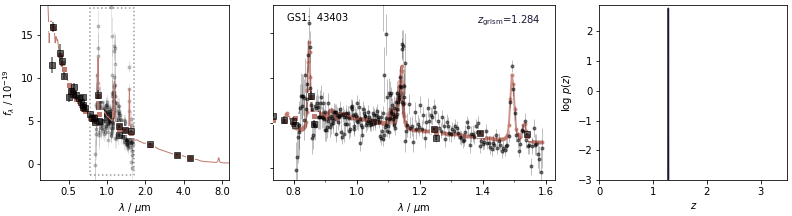

In [18]:
Image(filename = PATH_TO_PREP + '/GS1_43403.sed.png', width = 1000, height = 1000)

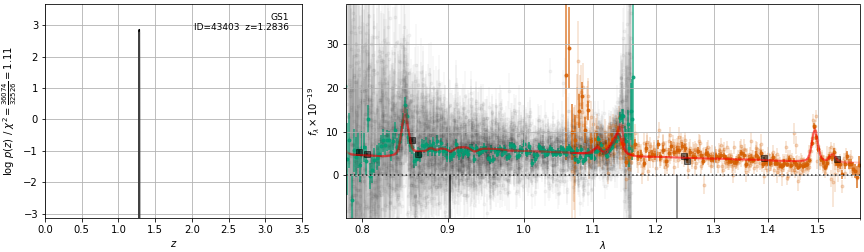

In [19]:
Image(filename = PATH_TO_PREP + '/GS1_43403.full.png', width = 1000, height = 1000)

### Emission line maps

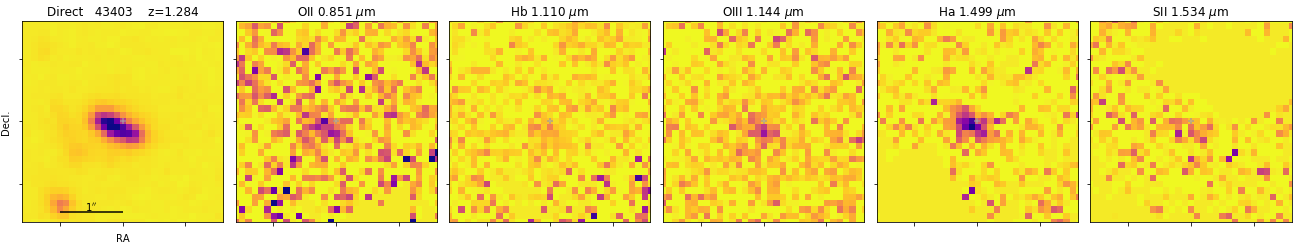

In [20]:
Image(filename = PATH_TO_PREP + '/GS1_43403.line.png', width = 1000, height = 1000)

### Fits files

In [21]:
fits_files = glob.glob('GS1_43403*fits')
for file in fits_files:
    im = fits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



GS1_43403.stack.fits


Filename: GS1_43403.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  SCI         G102,182.0 ImageHDU        66   (178, 64)   float32   
  2  WHT         G102,182.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,182.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,182.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,182.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102,205.0 ImageHDU        66   (178, 64)   float32   
  7  WHT         G102,205.0 ImageHDU        22   (178, 64)   float32   
  8  CONTAM      G102,205.0 ImageHDU        22   (178, 64)   float32   
  9  MODEL       G102,205.0 ImageHDU        24   (178, 64)   float32   
 10  KERNEL      G102,205.0 ImageHDU        22   (64, 64)   float32   
 11  SCI         G102,225.0 ImageHDU        66   (178, 64)   float32   
 12  WHT         G102,225.0 ImageHDU     

### The results of the fit are stored in *full.fits

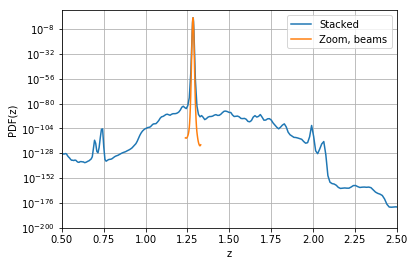

In [22]:
full_fits = fits.open('GS1_43403.full.fits')
zfit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


plt.plot(fit_stack['zgrid'], fit_stack['pdf'], label='Stacked')

# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   
plt.plot(fit_beam['zgrid'], fit_beam['pdf'], label='Zoom, beams')

plt.xlim(0.5, 2.5); plt.semilogy(); plt.grid()
plt.ylim(1.e-200, 1.e10)

plt.xlabel('z'); plt.ylabel('PDF(z)'); plt.legend()


### 1D line fluxes

In [23]:
full_fits = fits.open('GS1_43403.full.fits')
full_hdr = full_fits[0].header
numlines = full_hdr['NUMLINES']


print ('%i lines detected'%numlines)
for n in np.arange(numlines):
    line_name = full_hdr['LINE%.3i'%(n+1)]
    line_flux = full_hdr['FLUX%.3i'%(n+1)]
    line_err  = full_hdr['ERR%.3i'%(n+1)]
    
    print ('\t\t\t' + line_name)
    print ('\t  flux =  %.2f'%(1.e17 * line_flux), 'x 10^-17 erg/s/cm^2')
    print ('\t eflux =  %.2f'%(1.e17 * line_err), 'x 10^-17 erg/s/cm^2')
    print ('\t\t flux/eflux =  %.1f'%(line_flux/line_err))

    print ('\n\n\n')




5 lines detected
			SII
	  flux =  3.38 x 10^-17 erg/s/cm^2
	 eflux =  0.88 x 10^-17 erg/s/cm^2
		 flux/eflux =  3.8




			Ha
	  flux =  12.52 x 10^-17 erg/s/cm^2
	 eflux =  0.70 x 10^-17 erg/s/cm^2
		 flux/eflux =  17.9




			OIII
	  flux =  10.17 x 10^-17 erg/s/cm^2
	 eflux =  0.66 x 10^-17 erg/s/cm^2
		 flux/eflux =  15.5




			Hb
	  flux =  2.78 x 10^-17 erg/s/cm^2
	 eflux =  0.42 x 10^-17 erg/s/cm^2
		 flux/eflux =  6.6




			OII
	  flux =  9.60 x 10^-17 erg/s/cm^2
	 eflux =  0.85 x 10^-17 erg/s/cm^2
		 flux/eflux =  11.3






In [24]:
full_hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                43403 / Object ID                                      
RA      =         53.256524993 / Central R.A.                                   
DEC     =   -27.70794341100001 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                   28 / Number of drizzled beams                       
FILE0001= 'ibhj01iqq_flt.fits' / Parent filename                                
GRIS0001= 'G141    '           / Beam grism element                             
PA0001  =                132

<h1><center>Batch-mode fitting</center></h1>

### Wrapper for fitting routines above

In [ ]:
def grizli_fit(grp, id_fit, field = '', ref_filter = 'F105W', use_pz_prior = True, use_phot = True, scale_phot = True, templ0 = None, templ1 = None, ep = None, pline = None):
    beams = grp.get_beams(id_fit, size=80)
    if beams != []:
        print("beams: ", beams)
        mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
        mb.write_master_fits()

        # Fit polynomial model for initial continuum subtraction
        wave = np.linspace(2000,2.5e4,100)
        poly_templates = grizli.utils.polynomial_templates(
            wave=wave, 
            order=7,
            line=False)

        pfit = mb.template_at_z(
            z=0, 
            templates=poly_templates, 
            fit_background=True, 
            fitter='lstsq', 
            fwhm=1400, 
            get_uncertainties=2)


        if pfit != None:
        # Drizzle grisms / PAs
            hdu, fig = mb.drizzle_grisms_and_PAs(
                size=32, 
                fcontam=0.2, 
                flambda=False, 
                scale=1, 
                pixfrac=0.5, 
                kernel='point', 
                make_figure=True, 
                usewcs=False, 
                zfit=pfit,
                diff=True)
            # Save drizzled ("stacked") 2D trace as PNG and FITS
            fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
            hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



            if use_pz_prior:
                #use redshift prior from z_phot
                prior = np.zeros((2, len(p.tempfilt['zgrid'])))
                prior[0] = p.tempfilt['zgrid']
                prior[1] = p.pz['chi2fit'][:,id]
            else:
                prior = None 
            order = 0



            tab = utils.GTable()
            tab['ra'] = [mb.ra]
            tab['dec'] = [mb.dec]

            tab['id'] = id_fit
            phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
            out = grizli.fitting.run_all(
                id_fit, 
                t0=templ0, 
                t1=templ1, 
                fwhm=1200, 
                zr=[0.0, 3.5], 
                dz=[0.004, 0.0005], 
                fitter='nnls',
                group_name=field,
                fit_stacks=True, 
                prior=None, 
                fcontam=0.,
                pline=pline, 
                mask_sn_limit=7, 
                fit_only_beams=False,
                fit_beams=True, 
                root=field,
                fit_trace_shift=False, 
                phot=phot, 
                verbose=True, 
                scale_photometry=order, 
                show_beams=True)
            mb, st, fit, tfit, line_hdu = out
            fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

            fit_hdu.info()
            # same as the fit table above, redshift fit to the stacked spectra
            fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


            # zoom in around the initial best-guess with the individual "beam" spectra
            fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

            templ = Table(fit_hdu['TEMPL'].data)
            print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

            # Helper script for plotting them, not generated automatically
            fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
            fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
            plt.close('all')



### Fitting every object in the field with jh mag < 22

In [ ]:
#Fit all objects with MAG_AUTO < 22
if False:
    good = np.where(np.array(grp.catalog['MAG_AUTO']) < 22)[0]
    for g in good:
        id_fit = np.array(grp.catalog['NUMBER'])[g]
        mag_fit = grp.catalog['MAG_AUTO'][g]
        grizli_fit(grp, id_fit = id_fit, field = field,
                   use_pz_prior = False, use_phot = True, scale_phot = True,
                   templ0 = templ0, templ1 = templ1, ep = ep, pline = pline,)
        
